In [13]:
import numpy as np
import numba
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import hamming
from scipy.optimize import linear_sum_assignment
from time import time
from matplotlib import animation, rc
from sklearn.preprocessing import PolynomialFeatures
import pandas as pd
sns.set()
# Import Tabu Sampler
from tabu_class import tabu_sampler

@numba.njit()
def autocorr(x, lags):
    mean=np.mean(x)
    var=np.var(x)
    xp=x-mean
    corr=[1. if l==0 else np.sum(xp[l:]*xp[:-l])/len(x)/var for l in lags]

    return np.array(corr)

%matplotlib inline


In [14]:
# Load data

mangle_data = False

if mangle_data:
    data = pd.read_excel("Concrete_Data.xls")
    
    # Remove regressor
    y = data["Concrete compressive strength(MPa, megapascals) "].values
    data = data.drop(["Concrete compressive strength(MPa, megapascals) "], axis=1)
    
    # Add logs
    data["Log_Cement"] = np.log(data["Cement (component 1)(kg in a m^3 mixture)"])
    data["Log_Water"] = np.log(data["Water  (component 4)(kg in a m^3 mixture)"])
    data["Log_Coarse"] = np.log(data["Coarse Aggregate  (component 6)(kg in a m^3 mixture)"])
    data["Log_Fine"] = np.log(data["Fine Aggregate (component 7)(kg in a m^3 mixture)"])
    data["Log_Age"] = np.log(data["Age (day)"])
    
    extractor = PolynomialFeatures(2, interaction_only=True, include_bias=True)
    
    data = extractor.fit_transform(data)
else: 
    data = pd.read_csv("concrete.csv")
    y = data["COMPRESSIVE_STRENGTH"]
    data = data.drop(["COMPRESSIVE_STRENGTH"], axis=1)
    colnames = data.columns
    data = data.values
    
# Parameters
m = data.shape[0]
n = data.shape[1]

w = 4
lambd = np.linalg.lstsq(data, y, rcond=None)[1]/(data.shape[0] - data.shape[1])
nu_sq = 10./lambd

y_inner = np.sum(y**2)

In [15]:
def energy_func(state, data=data, y=y, nu_sq=nu_sq):
    indices = np.nonzero(np.ravel(state))[0]
    active_parameters = int(np.sum(state))
    
    data_subset = data[:, indices]
    
    C = np.linalg.cholesky(np.matmul(data_subset.T, data_subset) + np.eye(active_parameters) * nu_sq **-1)
    C_inv = np.linalg.inv(C)
    b = np.dot(data_subset.T, y)
    
    C_inv_b = np.dot(C_inv, b)
    
    sigma_estimate = 1/m * (y_inner - np.dot(C_inv_b.T, C_inv_b))
    
    energy = - np.sum(np.log(np.diag(C))) - active_parameters * np.log(np.sqrt(nu_sq)) - (w+m)/2 * np.log(w*lambd/m + sigma_estimate)
    
    return energy

def calc_rates(state, jump_rates=0, jump_rates_sum=0, generator_index=0):
    rate_vector = np.zeros(n)
    
    base_energy = energy_func(state)
    
    for i in np.arange(n):
        flipped_state = state.copy()
        flipped_state[i] = 1 - flipped_state[i]
        
        new_energy = energy_func(flipped_state)
        
        rate_global = np.exp(new_energy - base_energy)
        
        rate_vector[i] = rate_global/(1+rate_global)
        
    return rate_vector

def apply_gen(state, generator_index):
    updated_state = state.copy()
    updated_state[generator_index] = 1 - updated_state[generator_index]
    
    return updated_state

In [16]:
T = 25000
thinning_ratio = 0.25
N = int(T/thinning_ratio)
initial_state = np.zeros(n)
initial_state[0:9] = 1

samples, energy, hammings, alpha, iters, runtime = tabu_sampler(n, n,
                                                              energy_function=energy_func,
                                                              calculate_rates=calc_rates,
                                                              update_rates=calc_rates,
                                                              apply_generator=apply_gen,
                                                              current_state=initial_state,
                                                              baseline_state=np.ones(n),
                                                              target_time=T,
                                                              thin_rate=thinning_ratio,
                                                              time_change_rate=10e-10,
                                                              symmetry=False,
                                                              SAW_bool=True,
                                                              print_output=False,
                                                              calc_hamming=False)

# Update type of samples
samples = samples.astype("int8") 

Percent: [--------------------------------------->] 100%[25000.71503973]
Average SAW length: 6.0
Average jump length: [0.22570341]
Runtime: 1575.22


Mean number of samples: 28.21775


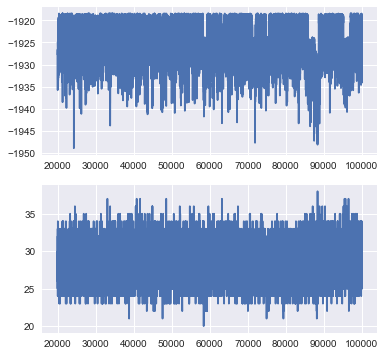

In [17]:
%matplotlib inline
plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
ax1.plot(np.arange(int(0.2*N), N), energy[int(0.2*N):])
ax2 = plt.subplot(212)
ax2.plot(np.arange(int(0.2*N), N), samples[int(0.2*N):].sum(axis=1))
print("Mean number of samples:", np.mean(samples.sum(axis=1)))

Total ESS: 2013.9448488197497
ESS/S: 1.278514810760428


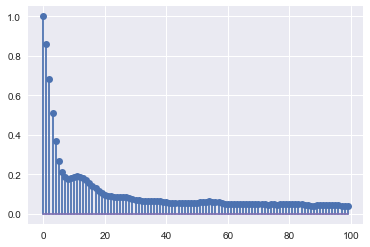

In [18]:
fig, ax = plt.subplots()
ax.stem(autocorr(samples[int(0.2*N):].sum(axis=1), np.arange(0, 100)))
ESS_E = N/(1+2*sum(autocorr(samples[int(0.2*N):].sum(axis=1), np.arange(0, 1000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime)

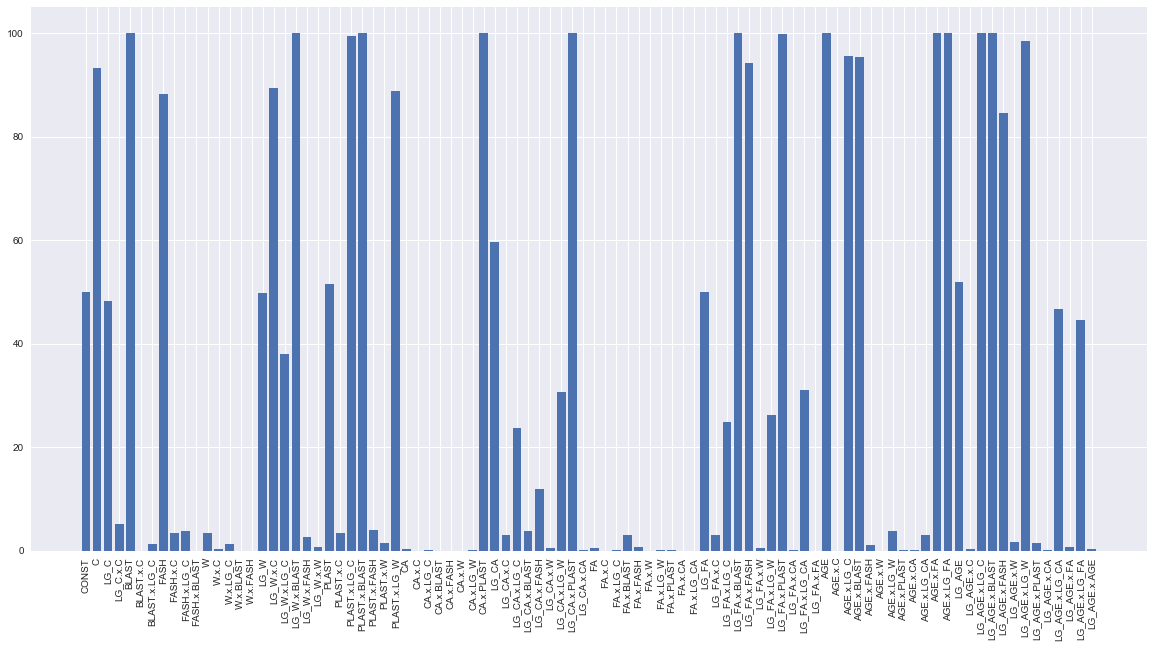

In [19]:
plt.figure(figsize=(20,10))
plt.bar(range(0,n), samples[np.arange(int(0.2*N), N)].sum(axis=0)/(0.8*N)*100)
plt.xticks(np.arange(n), colnames)
plt.tick_params(axis="x", rotation=90)

In [20]:
T = 14000
thinning_ratio = 0.14
N = int(T/thinning_ratio)

samples_z, energy_z, hammings, alpha, iters, runtime_z = tabu_sampler(n, n,
                                                              energy_function=energy_func,
                                                              calculate_rates=calc_rates,
                                                              update_rates=calc_rates,
                                                              apply_generator=apply_gen,
                                                              current_state=initial_state,
                                                              baseline_state=np.ones(n),
                                                              target_time=T,
                                                              thin_rate=thinning_ratio,
                                                              time_change_rate=10,
                                                              symmetry=False,
                                                              SAW_bool=False,
                                                              print_output=False,
                                                              print_rate=1000,
                                                              calc_hamming=False)

# Update type of samples
samples_z = samples_z.astype("int8") 

Percent: [--------------------------------------->] 100%[14000.05344443]
Average jump length: [0.13312338]
Runtime: 1788.27


Mean number of samples: 28.21775


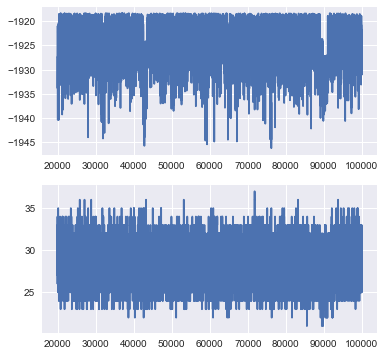

In [21]:
%matplotlib inline
plt.figure(figsize=(6,6))
ax1 = plt.subplot(211)
ax1.plot(np.arange(int(0.2*N), N), energy_z[int(0.2*N):])
ax2 = plt.subplot(212)
ax2.plot(np.arange(int(0.2*N), N), samples_z[int(0.2*N):].sum(axis=1))
print("Mean number of samples:", np.mean(samples.sum(axis=1)))

Total ESS: 1939.7242284218175
ESS/S: 1.0846942584992478


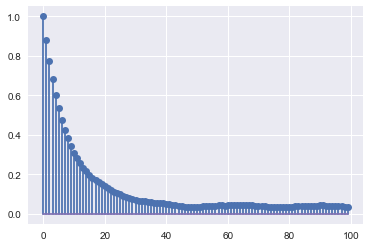

In [22]:
fig, ax = plt.subplots()
ax.stem(autocorr(samples_z[int(0.2*N):].sum(axis=1), np.arange(0, 100)))
ESS_E = N/(1+2*sum(autocorr(samples_z[int(0.2*N):].sum(axis=1), np.arange(0, 1000))))
print("Total ESS:", ESS_E)
print("ESS/S:", ESS_E/runtime_z)

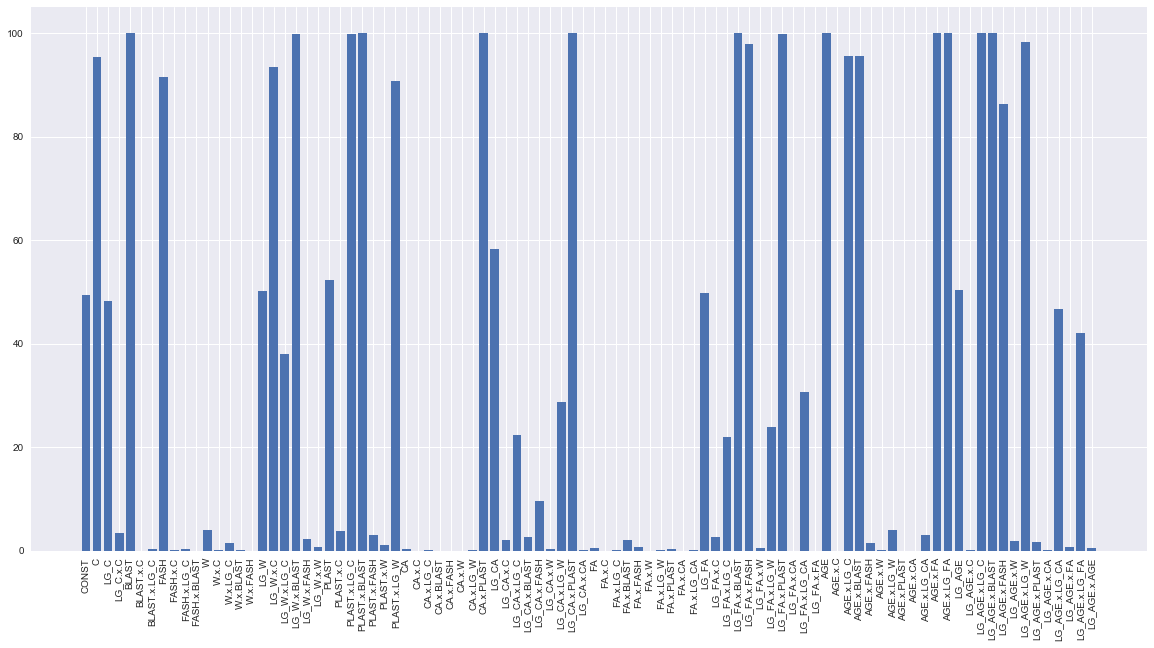

In [23]:
plt.figure(figsize=(20,10))
plt.bar(range(0,n), samples_z[np.arange(int(0.2*N), N)].sum(axis=0)/(0.8*N)*100)
plt.xticks(np.arange(n), colnames)
plt.tick_params(axis="x", rotation=90)